# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32#experiment with the batch size

In [60]:
data = train_doc[0:2]
data

array(['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n'],
      dtype='<U88')

In [155]:
from skimage import io
import glob
#f= open("info.txt","w+")
i = 0
count=0
scount=0
large=(360, 360, 3)
small=(120, 160, 3)

shape=[]
for path in train_doc:
        image_dir, sign , index = path.split(';')
        #print ("image_dir ",image_dir, "Sign ", sign ,"Sign Index ", index)
        #f.write("image_dir " + image_dir + "Sign " + sign  +"Sign Index " + index)
        image_path = os.path.join( 'Project_data','train',image_dir, '*')
        paths = glob.glob(image_path)
        #print("paths ", paths)
        #print(len(path)) #30
        for path  in paths:
            image = io.imread(path)
            #print(image.shape,path)
            #f.write(str(image.shape) + path+"\n")
            shape+=list(image.shape)
            i=i+1
            if (large == image.shape):
                count=count+1
            if (small == image.shape):
                scount=scount+1
#f.close() 
print("Total image",i,"360x360 image: ",count,"120x160 image ", scount)

Total image 19890 360x360 image:  5520 120x160 image  14370


In [154]:
myset = set(shape)
print(myset)
5520  + 14370

{120, 3, 360, 160}


19890

Shape  (360, 360, 3)
Shape  (120, 160, 3)
Scaled down shape  (120, 160, 3)
Scaled down shape  (120, 160, 3)


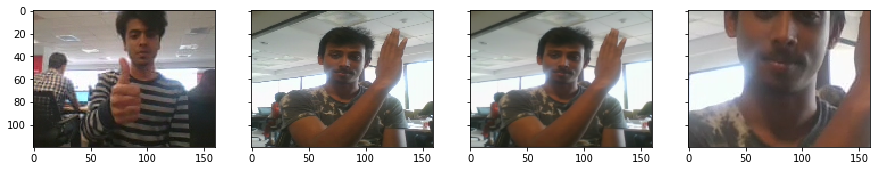

In [172]:
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)
        
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import rescale, resize, downscale_local_mean

#360x360 image
path="Project_data/train/WIN_20180907_16_12_53_Pro_Left Swipe_new_Left Swipe_new/WIN_20180907_16_12_53_Pro_00058.png"
image = io.imread(path)
print("Shape ",image.shape)

#120x160 image
path1="Project_data/train/WIN_20180926_16_41_01_Pro_Thumbs_Up_new/WIN_20180926_16_41_01_Pro_00013.png"
image1 = io.imread(path1)
print("Shape ",image1.shape)

# scaling 
image_resized_t = resize(image, (image.shape[0] / 3, image.shape[1] / 2.25), anti_aliasing=False)
image_resized_f = resize(image, (image.shape[0] / 3, image.shape[1] / 2.25), anti_aliasing=True)
print("Scaled down shape ",image_resized_t.shape)

if image.shape[0] > 120 and image.shape[1] > 160:
    h, w, _ = image.shape
    image2 = image[int(h/2)-60:int(h/2)+60, int(w/2)-80:int(w/2)+80, : ]
                
print("Scaled down shape ",image2.shape)

plot_image([image1, image_resized_t,image_resized_f,image2], cmap='gray')



## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [173]:
large=(360, 360, 3)
small=(120, 160, 3)
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [idx for idx in range(0,15,3)]#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = 8# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    print(image.shape,source_path,folder)
                    if (large == image.shape):
                        image = resize(image, (image.shape[0] / 3, image.shape[1] / 2.25), anti_aliasing=True)
                        image_path=source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                        plt.imsave(image_path, image, cmap = plt.cm.gray)

                    batch_data[folder,idx,:,:,0] = image[:, :, 0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:, :, 1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:, :, 2]/255#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [178]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5# choose the number of epochs
print ('# epochs =', num_epochs)
input_shape=(120, 160, 3)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [179]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D,Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
#3D convolutional model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3),
                 activation='relu',
                 input_shape=input_shape)) # input shape = (img_rows, img_cols, 1)

# second conv layer
model.add(Conv3D(64, kernel_size=(3, 3, 3), 
                 activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

ValueError: Input 0 is incompatible with layer conv3d_5: expected ndim=5, found ndim=4

In [19]:
help(Conv3D)

Help on class Conv3D in module keras.layers.convolutional:

class Conv3D(_Conv)
 |  Conv3D(filters, kernel_size, strides=(1, 1, 1), padding='valid', data_format=None, dilation_rate=(1, 1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
 |  
 |  3D convolution layer (e.g. spatial convolution over volumes).
 |  
 |  This layer creates a convolution kernel that is convolved
 |  with the layer input to produce a tensor of
 |  outputs. If `use_bias` is True,
 |  a bias vector is created and added to the outputs. Finally, if
 |  `activation` is not `None`, it is applied to the outputs as well.
 |  
 |  When using this layer as the first layer in a model,
 |  provide the keyword argument `input_shape`
 |  (tuple of integers, does not include the sample axis),
 |  e.g. `input_shape=(128, 128, 128, 1)` for 128x128x1

In [20]:
help(Conv2D)

Help on class Conv2D in module keras.layers.convolutional:

class Conv2D(_Conv)
 |  Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
 |  
 |  2D convolution layer (e.g. spatial convolution over images).
 |  
 |  This layer creates a convolution kernel that is convolved
 |  with the layer input to produce a tensor of
 |  outputs. If `use_bias` is True,
 |  a bias vector is created and added to the outputs. Finally, if
 |  `activation` is not `None`, it is applied to the outputs as well.
 |  
 |  When using this layer as the first layer in a model,
 |  provide the keyword argument `input_shape`
 |  (tuple of integers, does not include the sample axis),
 |  e.g. `input_shape=(128, 128, 3)` for 128x128 RGB pictures


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
optimiser = optimizers.SGD()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Instructions for updating:
Colocations handled automatically by placer.


NameError: name 'model' is not defined

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)